In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from keras.models import Sequential
from keras.layers import Dense,Dropout


working_dir = '/kaggle/input/store-sales-time-series-forecasting/'

In [3]:
df = pd.read_csv(working_dir + 'train.csv', parse_dates = ['date'])
df["is_weekend"] = df['date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
df.head()

,id,date,store_nbr,family,sales,onpromotion,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0


In [4]:
stores = pd.read_csv(working_dir + 'stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
df = df.merge(stores, on='store_nbr', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13


In [6]:
holidays = pd.read_csv(working_dir + 'holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])

holidays_nat = holidays[holidays['locale']=='National'].drop(['type', 'description', 'transferred'], axis=1).reset_index()
holidays_nat = holidays_nat.drop_duplicates(subset=['date']).reset_index()
holidays_nat = holidays_nat.drop(['index', 'level_0'], axis=1)

holidays_loc = holidays[holidays['locale']=='Local'].drop(['type', 'description', 'transferred'], axis=1).reset_index()
holidays_loc = holidays_loc.drop(['index', 'locale'], axis=1)

holidays_reg = holidays[holidays['locale']=='Regional'].drop(['type', 'description', 'transferred'], axis=1).reset_index()
holidays_reg = holidays_reg.drop(['index', 'locale'], axis=1)

In [7]:
df = df.merge(holidays_nat, on='date', how='left').reset_index()
df['locale'] = df['locale'].fillna(0)
df['national_holiday'] = df['locale'].replace('National', 1)
df = df.drop(['locale', 'locale_name', 'index'], axis=1)
df.head()

,id,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,national_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,1
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,1
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,1
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,1


In [8]:
df = pd.merge(df, holidays_reg, how='left', 
                             left_on=['date', 'state'], right_on=['date', 'locale_name'])
df['locale_name'] = df['locale_name'].fillna(0)
df['reg_holiday'] = df['locale_name']
df.loc[df['reg_holiday']!=0, 'reg_holiday'] = 1
df = df.drop(['locale_name'], axis=1)
df.head()

,id,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,national_holiday,reg_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,1,0


In [9]:
df = df.drop(['id'], axis=1)
df.head()

,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,national_holiday,reg_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,1,0
1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,1,0
2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,1,0
3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,1,0
4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,1,0


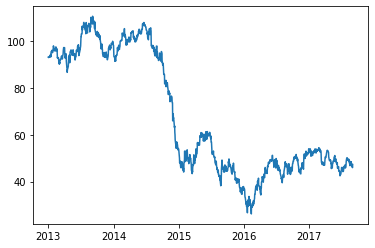

In [10]:
oil_price = pd.read_csv(working_dir + 'oil.csv')
oil_price['date'] = pd.to_datetime(oil_price['date'])
oil_price = oil_price.rename(columns={'dcoilwtico':'oil_price'})
oil_price = oil_price.fillna(method='ffill')
oil_price = oil_price.fillna(method='bfill')
plt.plot(oil_price['date'], oil_price['oil_price'])

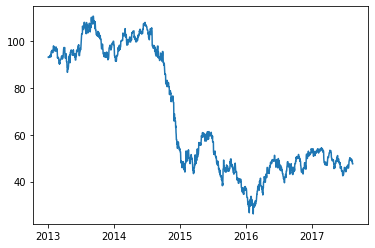

In [11]:
df = df.merge(oil_price, how='left', left_on='date', right_on='date')
df['oil_price'] = df['oil_price'].fillna(method='ffill')
plt.plot(df['date'], df['oil_price'])
plt.show()

In [12]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 10))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [13]:
sales_by_date = df[['sales', 'date']].groupby(['date']).mean()
sales_by_date.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


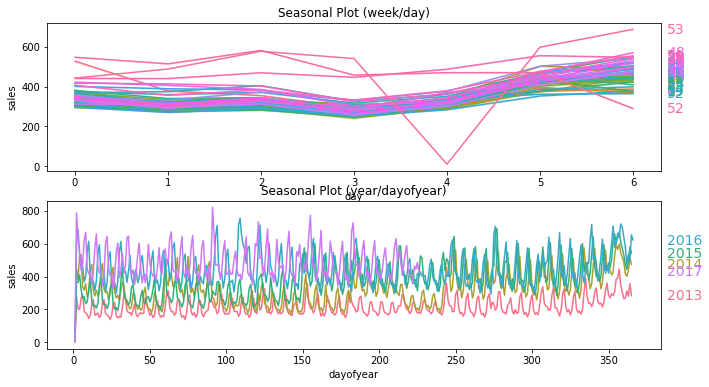

In [14]:
X = sales_by_date.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

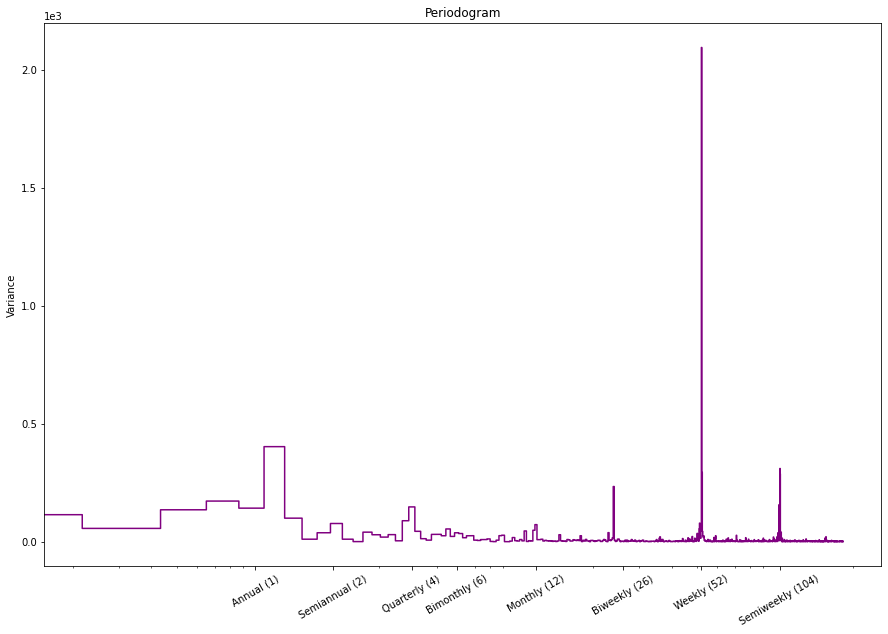

In [15]:
plot_periodogram(sales_by_date.sales)

In [16]:
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df.loc[:, days_of_week] = 0

In [17]:
for n, day in enumerate(days_of_week):
    df.loc[df['date'].dt.weekday==n, '{}'.format(day)] = 1
    
df.head()

,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,national_holiday,reg_holiday,oil_price,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,1,0,93.14,0,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,1,0,93.14,0,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,1,0,93.14,0,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,1,0,93.14,0,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,1,0,93.14,0,1,0,0,0,0,0


In [18]:
timestamp_s = df['date'].map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day
semi_year = year / 2
quater = year / 4
month = year / 12

df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['half_year_sin'] = np.sin(timestamp_s * (2 * np.pi / semi_year))
df['half_year_cos'] = np.cos(timestamp_s * (2 * np.pi / semi_year))
df['quater_sin'] = np.sin(timestamp_s * (2 * np.pi / quater))
df['quater_cos'] = np.cos(timestamp_s * (2 * np.pi / quater))
df['month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))

df.head()

,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,...,Sat,Sun,year_sin,year_cos,half_year_sin,half_year_cos,quater_sin,quater_cos,month_sin,month_cos
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025
1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025
2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025
3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025
4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025


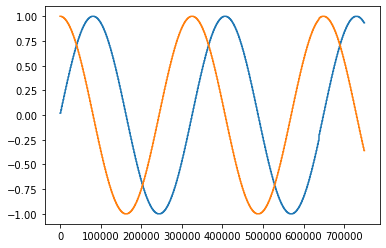

In [19]:
plt.plot(np.array(df['half_year_sin'])[:750000])
plt.plot(np.array(df['half_year_cos'])[:750000])

In [20]:
df['date']= pd.to_datetime(df['date'])
first_day = df['date'][0]
df['day_count'] = df['date'] - first_day
df['day_count'] = df['day_count'].dt.days

In [21]:
df.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_weekend',
       'city', 'state', 'type', 'cluster', 'national_holiday', 'reg_holiday',
       'oil_price', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
       'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin',
       'quater_cos', 'month_sin', 'month_cos', 'day_count'],
      dtype='object')

In [22]:
dummies = pd.get_dummies(df[['family', 'city', 'state', 'type', 'store_nbr', 'cluster']].astype(str))
dummies.columns

Index(['family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       ...
       'cluster_16', 'cluster_17', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'],
      dtype='object', length=147)

In [23]:
df = df.merge(dummies, how='left', left_index=True, right_index=True)
df.head()

,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,...,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0


In [24]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [25]:
df.tail()

,date,store_nbr,family,sales,onpromotion,is_weekend,city,state,type,cluster,national_holiday,reg_holiday,oil_price,Mon,Tue,Wed,Thu,Fri,Sat,Sun,year_sin,year_cos,half_year_sin,half_year_cos,quater_sin,quater_cos,month_sin,month_cos,day_count,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Azuay,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_2,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_3,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_4,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_5,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
3000883,2017-08-15,9,POULTRY,438.133,0,0,Quito,Pichincha,B,6,0,0,47.57,0,1,0,0,0,0,0,-0.686453,-0.727174,0.998342,0.057565,0.11494,-0.993372,0.338745,-0.940878,1687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,0,Quito,Pichincha,B,6,0,0,47.57,0,1,0,0,0,0,0,-0.686453,-0.727174,0.998342,0.057565,0.11494,-0.993372,0.338745,-0.940878,1687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3000885,2017-08-15,9,PRODUCE,2419.729,148,0,Quito,Pichincha,B,6,0,0,47.57,0,1,0,0,0,0,0,-0.686453,-0.727174,0.998342,0.057565,0.11494,-0.993372,0.338745,-0.940878,1687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,0,Quito,Pichincha,B,6,0,0,47.57,0,1,0,0,0,0,0,-0.686453,-0.727174,0.998342,0.057565,0.11494,-0.993372,0.338745,-0.940878,1687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [26]:
df = df.drop(['family', 'city', 'state', 'type', 'store_nbr', 'cluster'], axis=1)
date_column = df.pop('date')
df.head()

,sales,onpromotion,is_weekend,national_holiday,reg_holiday,oil_price,Mon,Tue,Wed,Thu,Fri,Sat,Sun,year_sin,year_cos,half_year_sin,half_year_cos,quater_sin,quater_cos,month_sin,month_cos,day_count,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Azuay,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_2,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_3,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_4,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_5,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0.0,0,0,1,0,93.14,0,1,0,0,0,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,1,0,93.14,0,1,0,0,0,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,1,0,93.14,0,1,0,0,0,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,1,0,93.14,0,1,0,0,0,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,1,0,93.14,0,1,0,0,0,0,0,0.009848,0.999952,0.019696,0.999806,0.039384,0.999224,0.117908,0.993025,0,0,0,0,0,1,0,0,0,

In [27]:
train_df = df[:int(len(df)*0.8)]
val_df = df[int(len(df)*0.8):]
y_train = train_df.pop('sales')
y_val = val_df.pop('sales')

In [28]:
train_cols_norm = train_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].copy()
val_cols_norm = val_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].copy()

train_mean = train_cols_norm.mean()
train_std = train_cols_norm.std()

train_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] = \
(train_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] - train_mean) / train_std

val_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] = \
(val_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] - train_mean) / train_std

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [29]:
print(train_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].mean())
print(train_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].std())
print(val_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].mean())
print(val_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', \
                                   'half_year_sin', 'half_year_cos', 'quater_sin', 'quater_cos', 'month_sin', \
                                   'month_cos', 'day_count']].std())

onpromotion      7.852727e-17
oil_price        3.371712e-17
year_sin        -9.433217e-17
year_cos        -8.275375e-17
half_year_sin   -3.113625e-17
half_year_cos   -6.497175e-17
quater_sin       2.642437e-17
quater_cos      -1.131797e-17
month_sin        4.053631e-17
month_cos        2.320420e-18
day_count        1.903691e-16
dtype: float64
onpromotion      1.0
oil_price        1.0
year_sin         1.0
year_cos         1.0
half_year_sin    1.0
half_year_cos    1.0
quater_sin       1.0
quater_cos       1.0
month_sin        1.0
month_cos        1.0
day_count        1.0
dtype: float64
onpromotion      0.595035
oil_price       -0.882456
year_sin         0.015370
year_cos         0.117810
half_year_sin   -0.154388
half_year_cos    0.026787
quater_sin       0.063695
quater_cos       0.078300
month_sin       -0.000907
month_cos       -0.014868
day_count        2.165188
dtype: float64
onpromotion      1.984272
oil_price        0.119468
year_sin         0.988980
year_cos         1.009500
half

In [30]:
train_df.shape

(2400710, 168)

In [31]:
train_df = train_df.to_numpy(dtype='float32')
val_df = val_df.to_numpy(dtype='float32')
y_train = y_train.to_numpy(dtype='float32')
y_val = y_val.to_numpy(dtype='float32')

In [32]:
"""dense_model = Sequential()
dense_model.add(Dense(64, activation ='relu', input_shape=(168,)))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(32, activation ='relu'))
dense_model.add(Dense(1))"""

"dense_model = Sequential()\ndense_model.add(Dense(64, activation ='relu', input_shape=(168,)))\ndense_model.add(Dropout(0.5))\ndense_model.add(Dense(32, activation ='relu'))\ndense_model.add(Dense(1))"

In [33]:
#dense_model.summary()

In [34]:
#dense_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [35]:
#history = dense_model.fit(train_df, y_train, epochs=50, batch_size=2048, validation_data=(val_df, y_val))

In [36]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [37]:
GB_model = HistGradientBoostingRegressor(verbose=1, max_iter=400, max_leaf_nodes=64, l2_regularization=0.1).fit(train_df, y_train)

Binning 2.904 GB of training data: 2.509 s
Binning 0.323 GB of validation data: 0.166 s
Fitting gradient boosted rounds:
[1/400] 1 tree, 64 leaves, max depth = 11, train loss: 446217.72644, val loss: 427475.43915, in 0.808s
[2/400] 1 tree, 64 leaves, max depth = 10, train loss: 380467.74641, val loss: 363507.07177, in 0.895s
[3/400] 1 tree, 64 leaves, max depth = 11, train loss: 326834.33663, val loss: 311351.78965, in 0.794s
[4/400] 1 tree, 64 leaves, max depth = 11, train loss: 282890.29699, val loss: 268529.93037, in 0.832s
[5/400] 1 tree, 64 leaves, max depth = 12, train loss: 247256.12325, val loss: 233971.84103, in 0.798s
[6/400] 1 tree, 64 leaves, max depth = 13, train loss: 217607.92357, val loss: 205195.68873, in 0.850s
[7/400] 1 tree, 64 leaves, max depth = 10, train loss: 193674.15887, val loss: 182037.50969, in 0.926s
[8/400] 1 tree, 64 leaves, max depth = 10, train loss: 173807.88561, val loss: 162793.04300, in 0.768s
[9/400] 1 tree, 64 leaves, max depth = 9, train loss: 1

In [38]:
GB_model.score(train_df, y_train)

0.9607034034452302

In [39]:
GB_model.score(val_df, y_val)

0.9281038654042739

In [40]:
#Preparing test_df
test_df = pd.read_csv(working_dir + 'test.csv', parse_dates = ['date'])
test_df["is_weekend"] = test_df['date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

#Merging with stores data
test_df = test_df.merge(stores, on='store_nbr', how='left')

#Merging with national and regional holidays data
test_df = test_df.merge(holidays_nat, on='date', how='left').reset_index()
test_df['locale'] = test_df['locale'].fillna(0)
test_df['national_holiday'] = test_df['locale'].replace('National', 1)
test_df = test_df.drop(['locale', 'locale_name', 'index'], axis=1)
test_df = pd.merge(test_df, holidays_reg, how='left', 
                             left_on=['date', 'state'], right_on=['date', 'locale_name'])
test_df['locale_name'] = test_df['locale_name'].fillna(0)
test_df['reg_holiday'] = test_df['locale_name']
test_df.loc[test_df['reg_holiday']!=0, 'reg_holiday'] = 1
test_df = test_df.drop(['locale_name'], axis=1)

test_df = test_df.drop(['id'], axis=1)

#Adding oil prices
test_df = test_df.merge(oil_price, how='left', left_on='date', right_on='date')
test_df['oil_price'] = test_df['oil_price'].fillna(method='ffill')

#Day of the week
test_df.loc[:, days_of_week] = 0
for n, day in enumerate(days_of_week):
    test_df.loc[test_df['date'].dt.weekday==n, '{}'.format(day)] = 1
    
#Adding time patterns
test_df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
test_df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
test_df['half_year_sin'] = np.sin(timestamp_s * (2 * np.pi / semi_year))
test_df['half_year_cos'] = np.cos(timestamp_s * (2 * np.pi / semi_year))
test_df['quater_sin'] = np.sin(timestamp_s * (2 * np.pi / quater))
test_df['quater_cos'] = np.cos(timestamp_s * (2 * np.pi / quater))
test_df['month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
test_df['month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))

test_df['date']= pd.to_datetime(test_df['date'])
first_day = test_df['date'][0]
test_df['day_count'] = test_df['date'] - first_day
test_df['day_count'] = test_df['day_count'].dt.days

#One-hot cat vars
test_df = test_df.merge(dummies, how='left', left_index=True, right_index=True)

#Drop useless cols
test_df = test_df.drop(['date', 'family', 'city', 'state', 'type', 'store_nbr', 'cluster'], axis=1)

#Normalize columns even it's not needed for GB model
test_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] = \
(test_df.loc[:, ['onpromotion', 'oil_price', 'year_sin', 'year_cos', 'half_year_sin', 'half_year_cos', 'quater_sin', \
                 'quater_cos', 'month_sin', 'month_cos', 'day_count']] - train_mean) / train_std

test_df = test_df.to_numpy(dtype='float32')

In [41]:
test_predict = GB_model.predict(test_df)

In [42]:
test_df = pd.read_csv(working_dir + 'test.csv', parse_dates = ['date'])

In [43]:
output = pd.DataFrame({'id': test_df.id, 'sales': np.round(test_predict, 3)})
output.head()

,id,sales
0,3000888,-62.084
1,3000889,-69.427
2,3000890,57.923
3,3000891,629.525
4,3000892,-66.430


In [44]:
output.to_csv('submission.csv', index=False)